
Use linear and nonlinear dimension reduction techniques (e.g. SVD, sparseSVD, kernelPCA, NMF, AE, tSNE) and filtering (testing) to explore the data set. 


Make sure to discuss:

*How the results differ between methods*

*How the dimension reduction techniques shed light on class separation, or lack thereof*

*How the dimension reduction techniques provide insight into the regions of the images that separate the classes*

*How you handled the large number of observations*

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import math
from itertools import zip_longest
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.decomposition import KernelPCA, NMF
from scipy.linalg import svd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.ensemble import VotingClassifier

#to get rid of the warning
import warnings
warnings.filterwarnings('ignore')


In [6]:
data = pd.read_csv('MyMNIST.csv')

X = data.drop('label', axis=1)
target = data['label']


In [7]:
# print(data.head())

# print(X.head())
print(target.head())

labels = []
for target_value in target:
    if target_value not in labels:
        labels.append(target_value)
        
print(labels)

0    5
1    2
2    8
3    3
4    3
Name: label, dtype: int64
[5, 2, 8, 3, 9, 6, 1, 0, 4, 7]


In [8]:
seed = random.seed(42)

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=seed)


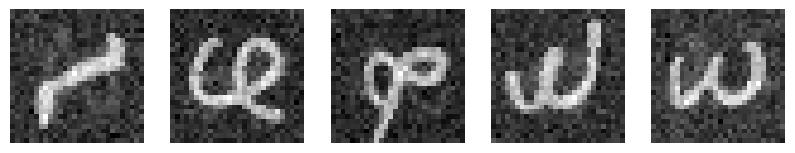

In [9]:
def get_digits_img(data, index, shape=(28,28)):
    
    img = data.iloc[index, 1:].to_numpy()

    img = img.reshape(shape).T
    return img


images = [get_digits_img(data, i) for i in range(5)]
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for ax, img in zip(axes, images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()

 batching for NMF to handle the data: 

In [10]:
#batch funciton: 

def batched_process(data, batch_size, transform_func):
    n_samples = data.shape[0]
    transformed_data = []
    
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        batch = data[start:end]
        transformed_batch = transform_func(batch)
        transformed_data.append(transformed_batch)
    
    return np.vstack(transformed_data)

batch_size = 100
n_components = 10

def nmf_transform(batch, n_components):
    nmf_model = NMF(n_components=n_components, init='random', random_state=0)
    return nmf_model.fit_transform(batch)


def svd_transform(batch):

    U, S, Vt = svd(batch, full_matrices=False)
    return U @ np.diag(S)


X_train_transformed_nmf_final = batched_process(X_train, batch_size, lambda batch: nmf_transform(batch, n_components))

X_train_transformed_svd_final = batched_process(X_train, batch_size, svd_transform)




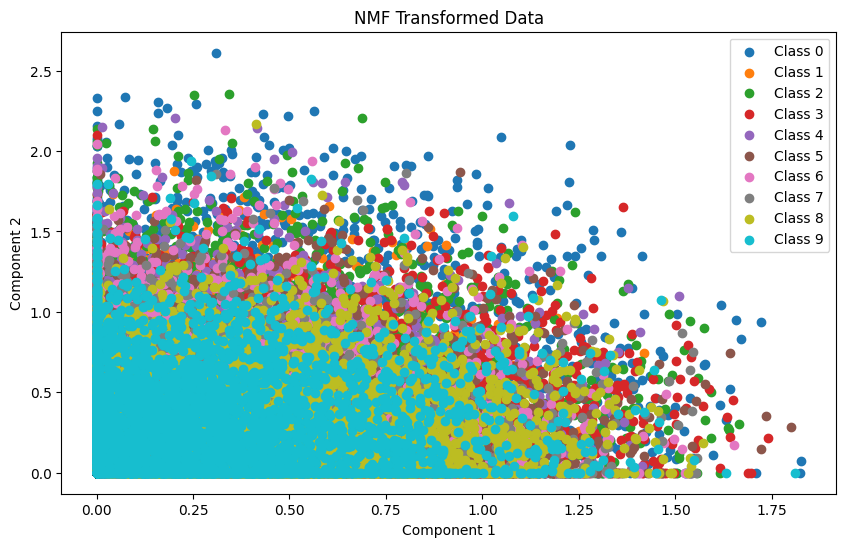

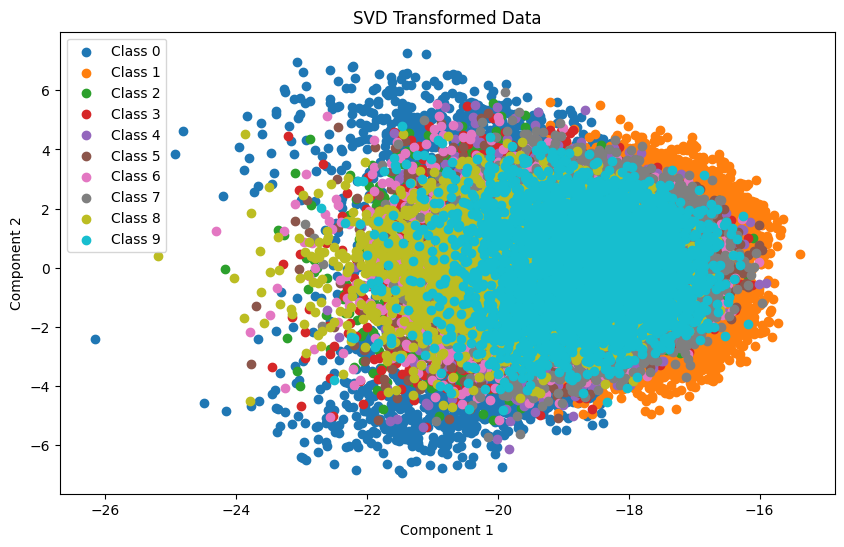

In [11]:


def plot_transformed_data(X_transformed, y, title):
    plt.figure(figsize=(10, 6))
    for class_value in np.unique(y):
        plt.scatter(X_transformed[y == class_value, 0], X_transformed[y == class_value, 1], label=f'Class {class_value}')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()


plot_transformed_data(X_train_transformed_nmf_final, target_train, 'NMF Transformed Data')

plot_transformed_data(X_train_transformed_svd_final, target_train, 'SVD Transformed Data')


Use KernelPCA with subsample of data to reduce the computaiton expences. and as a non-linear method:

In [12]:
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train)

subset_size = 10000
X_train_subset, _, = train_test_split(X_train_reduced, train_size=subset_size, random_state=42)


kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1)
X_train_subset_kpca = kpca.fit_transform(X_train_subset)

X_train_kpca = kpca.transform(X_train_reduced)

print("Training data shape after KernelPCA:", X_train_kpca.shape)



Training data shape after KernelPCA: (35000, 10)


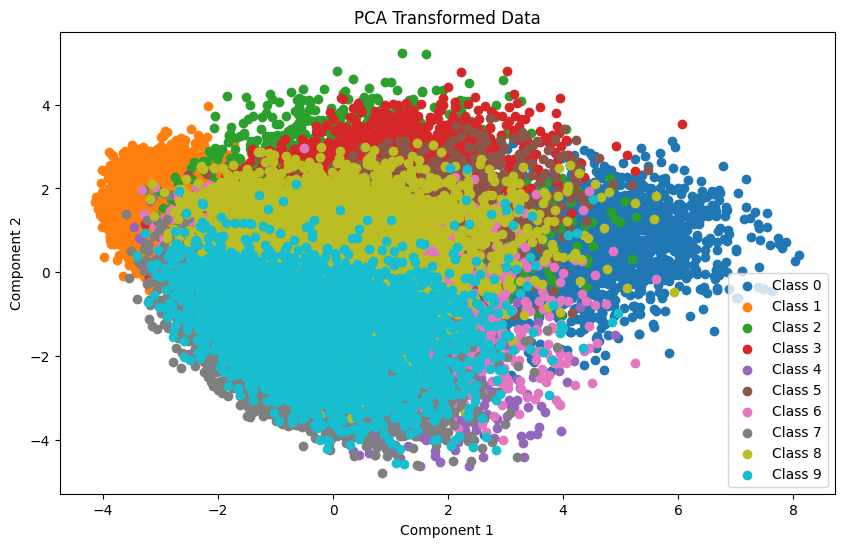

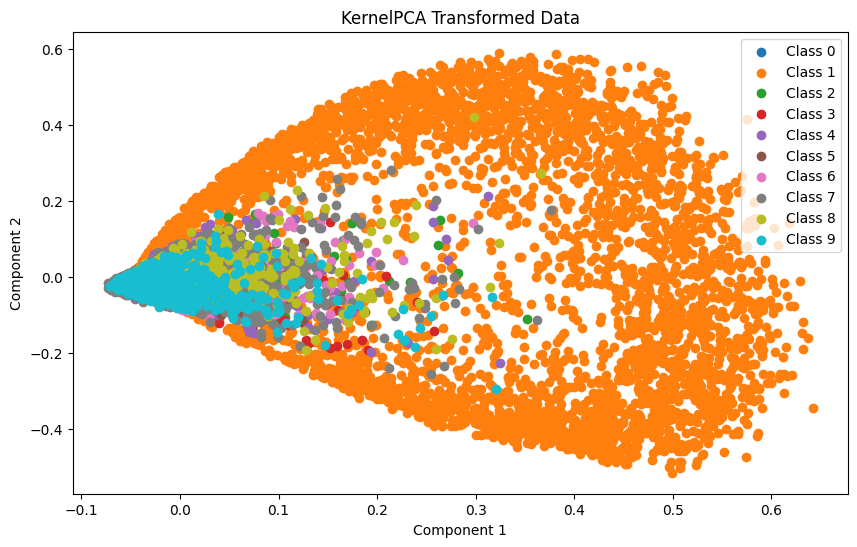

In [13]:
def plot_transformed_data(X_transformed, y, title):
    plt.figure(figsize=(10, 6))
    for class_value in np.unique(y):
        plt.scatter(X_transformed[y == class_value, 0], X_transformed[y == class_value, 1], label=f'Class {class_value}')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

plot_transformed_data(X_train_reduced, target_train, 'PCA Transformed Data')

plot_transformed_data(X_train_kpca, target_train, 'KernelPCA Transformed Data')

t-test as the filtering method: using ANOVA:


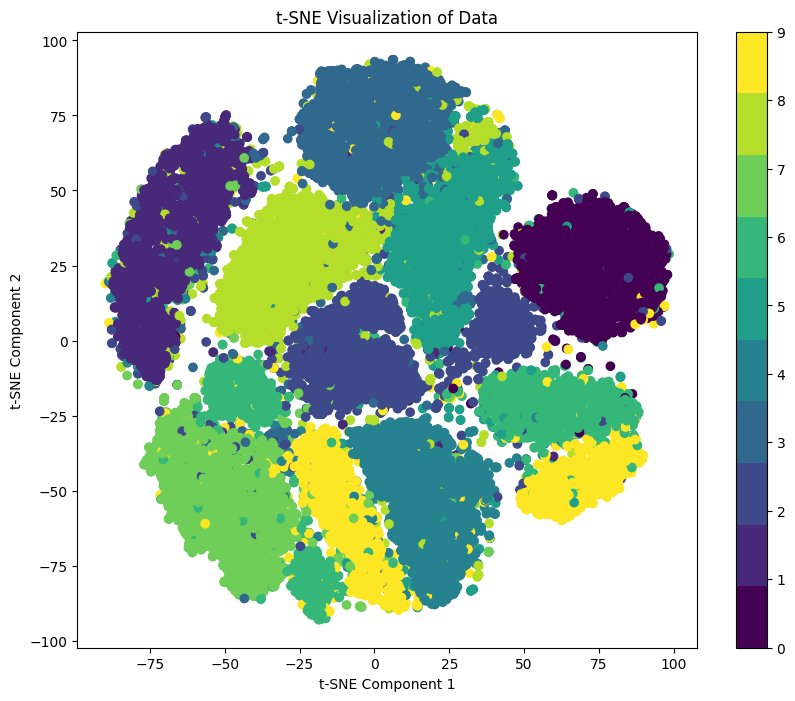

In [14]:

tsne = TSNE(n_components=2, perplexity=30, random_state=42)

X_train_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=target_train, cmap=plt.cm.get_cmap("viridis", 10))
plt.colorbar()
plt.title('t-SNE Visualization of Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


### 2b ### 

nvestigate classification performance as a function of training sample size on this data set. Make sure to use a wide range of classification methods (at least 5) and discuss what aspects of the data makes some methods perform worse than others.

Make sure to discuss:

How you adressed the dimensionality of the data set

Specific challenges in classifying this data set, looking at class distributions, potential mislabeleing, noise level etc

Method comparisons

Discuss how sample size impacts classification performance and relative performance between the methods.

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.pipeline import Pipeline

# Define classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN-10': KNeighborsClassifier(n_neighbors=10),
    'KNN-5': KNeighborsClassifier(n_neighbors=5),
    'SVM-Linear': SVC(kernel='linear', probability=True),
}


label_mapping = {label: idx for idx, label in enumerate(target.unique())}


training_sizes = np.linspace(0.2, 0.8, 4)
print(training_sizes)
y_train_int = target_train.map(label_mapping) 
y_test_int = target_test.map(label_mapping)

performance_results = {clf_name: {size: {} for size in training_sizes} for clf_name in classifiers.keys()}

confusion_matrices = {clf_name: None for clf_name in classifiers.keys()}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def batch_train(X_train, y_train, clf, batch_size=1500):
    models = []
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        pipeline = Pipeline([('Scaler', StandardScaler()), ('Classifier', clf)])
        pipeline.fit(X_batch, y_batch)
        models.append(pipeline)
    return models

for size in training_sizes:

    X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_tsne, y_train_int, train_size=size, stratify=y_train_int, random_state=42)
    y_train_sampled_int = y_train_sampled.map(label_mapping)
    
    for name, clf in classifiers.items():

        models = batch_train(X_train_sampled, y_train_sampled_int, clf)
        
        voting_clf = VotingClassifier(estimators=[(f'{name}_{i}', model) for i, model in enumerate(models)], voting='hard')
        
        y_pred = cross_val_predict(voting_clf, X_train_sampled, y_train_sampled_int, cv=cv)

        misclassified = np.where(y_train_sampled_int != y_pred)[0]
        if len(misclassified) > 0:
            print(f"Potential mislabeling detected for {name} with training size {size}")
            confusion_matrices[name] = confusion_matrix(y_train_sampled_int, y_pred)
        
        accuracy = accuracy_score(y_train_sampled_int, y_pred)
        f1 = f1_score(y_train_sampled_int, y_pred, average='weighted')
        

        performance_results[name][size]['accuracy'] = accuracy
        performance_results[name][size]['f1_score'] = f1

for clf_name in classifiers.keys():
    print(f"Results for {clf_name}:")
    for size in training_sizes:
        print(f"Training size {size}: Accuracy = {performance_results[clf_name][size]['accuracy']}, F1 Score = {performance_results[clf_name][size]['f1_score']}")


[0.2 0.4 0.6 0.8]
Potential mislabeling detected for RandomForest with training size 0.2
Potential mislabeling detected for LogisticRegression with training size 0.2
Potential mislabeling detected for KNN-10 with training size 0.2
Potential mislabeling detected for KNN-5 with training size 0.2
Potential mislabeling detected for SVM-Linear with training size 0.2
Potential mislabeling detected for RandomForest with training size 0.4
Potential mislabeling detected for LogisticRegression with training size 0.4
Potential mislabeling detected for KNN-10 with training size 0.4
Potential mislabeling detected for KNN-5 with training size 0.4
Potential mislabeling detected for SVM-Linear with training size 0.4
Potential mislabeling detected for RandomForest with training size 0.6000000000000001
Potential mislabeling detected for LogisticRegression with training size 0.6000000000000001
Potential mislabeling detected for KNN-10 with training size 0.6000000000000001
Potential mislabeling detected f

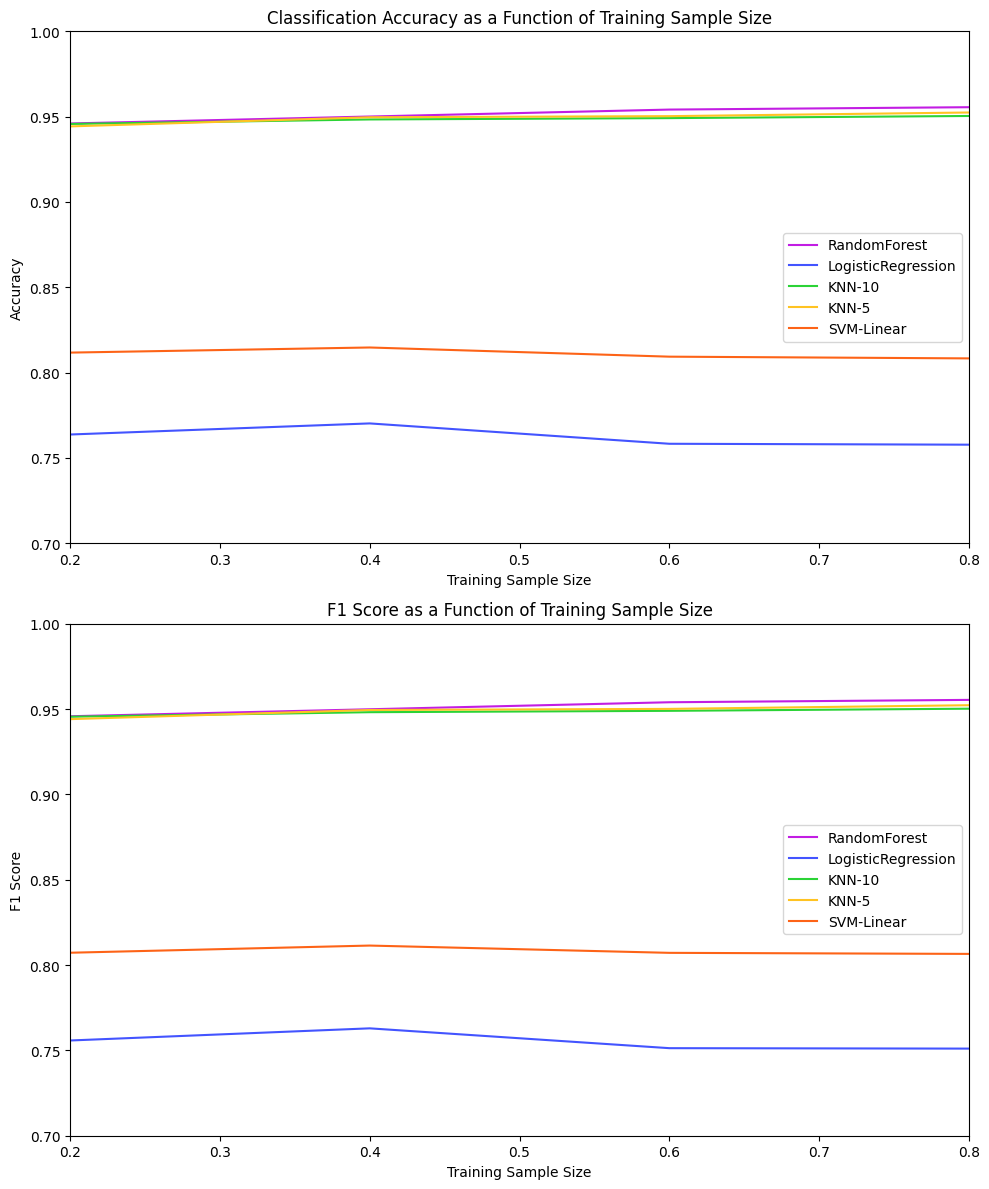

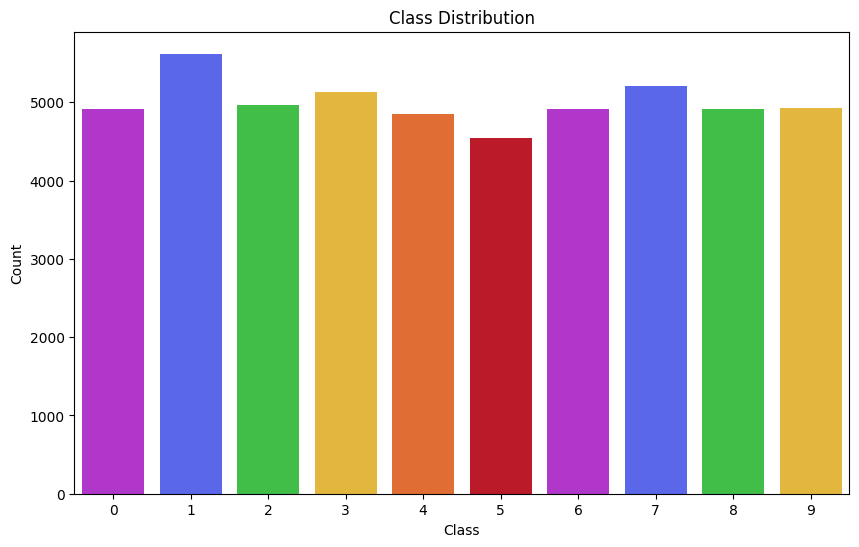

In [25]:

colors = ['#C21DE3', '#4354FF','#2BD336', '#FFC322','#FD6317',  '#D60013']

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Ensure that there are enough colors for each classifier
assert len(colors) >= len(classifiers)

for i, name in enumerate(classifiers.keys()):
    sizes = list(performance_results[name].keys())
    accuracy_values = [performance_results[name][size]['accuracy'] for size in sizes]
    f1_values = [performance_results[name][size]['f1_score'] for size in sizes]
    ax[0].plot(sizes, accuracy_values, label=name, color=colors[i])
    ax[1].plot(sizes, f1_values, label=name, color=colors[i], )

ax[0].set_title('Classification Accuracy as a Function of Training Sample Size')
ax[0].set_xlabel('Training Sample Size')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_xlim([0.2, 0.8])  # Adjust as needed
ax[0].set_ylim([0.7, 1.0])  # Adjust as needed

ax[1].set_title('F1 Score as a Function of Training Sample Size')
ax[1].set_xlabel('Training Sample Size')
ax[1].set_ylabel('F1 Score')
ax[1].legend()
ax[1].set_xlim([0.2, 0.8])  # Adjust as needed
ax[1].set_ylim([0.7, 1.0])  # Adjust as needed

plt.tight_layout()
plt.show()


# Analyze class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=target ,palette=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [26]:
def identify_mislabeled(y_true, y_pred):
    misclassified = np.where(y_true != y_pred)[0]
    return misclassified

pipeline1 = Pipeline([('Scaler', StandardScaler()), ('Classifier', RandomForestClassifier(n_estimators=100))])
pipeline1.fit(X_train, y_train_int)
y_pred = pipeline1.predict(X_test)

misclassified = identify_mislabeled(y_test_int, y_pred)

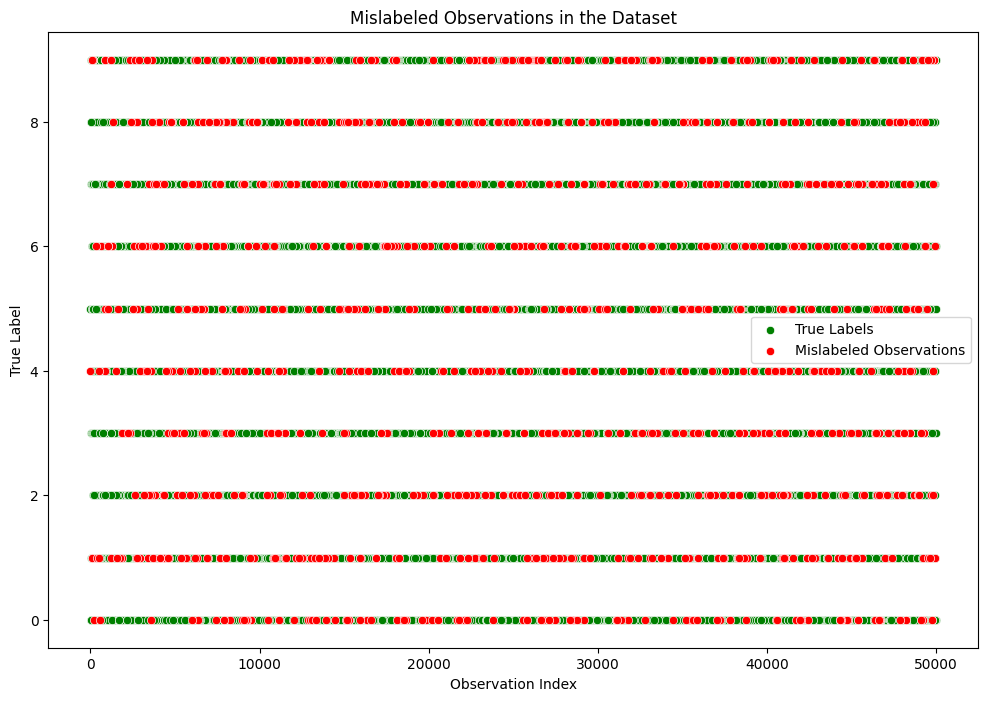

Misclassified Observations Indices: [   43    63    77 ... 14989 14990 14991]
Misclassified Observations:
              X1        X2        X3        X4        X5        X6        X7  \
10123  0.476819  0.577269  0.571501  0.360063  0.496656  0.513344  0.682952   
3301   0.486857  0.559322  0.591501  0.491283  0.476831  0.508487  0.722546   
14397  0.604492  0.386976  0.631136  0.396010  0.642467  0.680982  0.578679   
2626   0.665353  0.496548  0.483411  0.512994  0.406001  0.473108  0.374328   
21501  0.560838  0.625073  0.460099  0.540606  0.695299  0.598005  0.516381   
...         ...       ...       ...       ...       ...       ...       ...   
47737  0.670274  0.712101  0.461460  0.442495  0.413704  0.462264  0.591793   
11761  0.512838  0.537369  0.602587  0.569991  0.536830  0.547231  0.464446   
33744  0.433112  0.588629  0.476745  0.620863  0.574156  0.392688  0.558852   
30560  0.693801  0.749729  0.452953  0.327492  0.459494  0.458126  0.608815   
15254  0.513494  0.53820

In [22]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_test.index, y=target_test, color='green', label='True Labels')
sns.scatterplot(x=X_test.index[misclassified], y=target.iloc[misclassified], color='red', label='Mislabeled Observations')

plt.title('Mislabeled Observations in the Dataset')
plt.xlabel('Observation Index')
plt.ylabel('True Label')
plt.legend()
plt.show()

print("Misclassified Observations Indices:", misclassified)
print("Misclassified Observations:\n", X_test.iloc[misclassified])